## Context

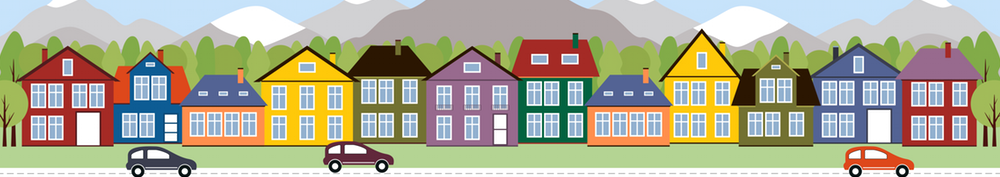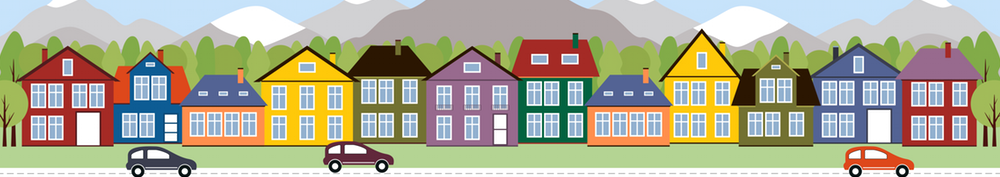

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

### Importing The Libraries

In [11]:
#importing the required liabraries

import pandas as pd
import numpy as np

#from sklearn.preprocessing import LableEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score,GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

### Importing The Given Data

In [13]:
# Convert the datasets into dataframe
df = pd.read_csv('Training Data//train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Exploratory Data Analysis

#### Distribution of Data

In [16]:
#get the shape of your dataframe
X_shape, y_shape = df.shape
print(X_shape, y_shape)

1460 81


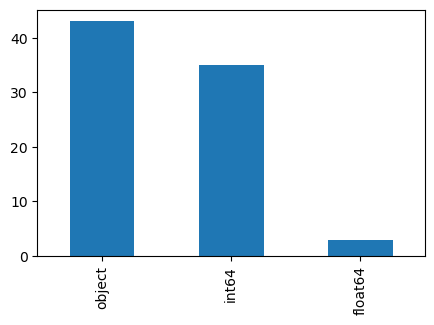

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [17]:
# get a detailed view of your dataframe
dtypes_count = df.dtypes.value_counts()
plt.figure(figsize=(5,3.2))
dtypes_count.plot.bar()
plt.show()
df_info = df.info()

#### Handling Missing Values

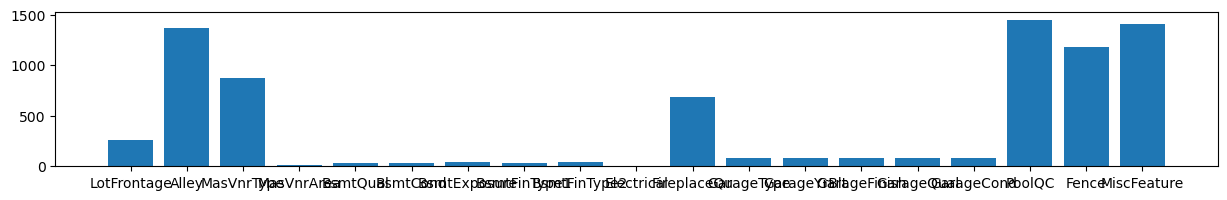

In [19]:
# Finds the columns which are having null values
def null_col_finder(df):
    df_col=df.isnull().sum() > 0.
    null_col = df_col[df_col==True].index.tolist()
    
    return null_col

null_col = null_col_finder(df)

plt.figure(figsize=(15,2))
plt.bar(null_col,df[null_col].isnull().sum())
plt.show()

In [20]:
#Delete the columns having more null values than the thresold.
def delete_columns_with_null(df, threshold=0.2):
    null_percentage = df.isnull().mean()  # Calculate null value percentage for each column
    columns_to_drop = null_percentage[null_percentage > threshold].index.tolist()
    # Drop columns with null value percentage greater than threshold
    df = df.drop(columns_to_drop, axis=1)
    return df
df = delete_columns_with_null(df)

In [21]:
#Delete the columsn having less variance than the thresold.
def col_variance(df,thresold=.1):
    col = df.dtypes != 'object'
    col_non_cat = col[col==True].index.tolist()
    var = df[col_non_cat].var()
    col_low_val = var[var<.1].index.tolist()
    df = df.drop(col_low_val, axis=1)
    return df

df = col_variance(df)

In [22]:
#Delete the rows having more null values than the thresold.
def delete_rows_with_null(df, threshold=0.75):
    null_rows = df.isnull().mean(1)
    null_rows_index = null_rows[null_rows>threshold].index.tolist()
    df = df.drop(index=null_rows_index)
    return df
df = delete_rows_with_null(df)
df = df.dropna()

In [23]:
#Delete the unnecessary columns and check the final shape
df = df.dropna()
df = df.drop('Id', axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [24]:
#Replace the null values of integer/float data type features

def Null_management_num(df):
    for col in df.columns:
        if df[col].dtypes != 'object':
            df.replace(to_replace=col,value=df[col].median())
            
    return df

df = Null_management_num(df)

#### Handling Catagorical Values

In [26]:
# Analyze the catagorival columns and find the required encoding for them

def cat_columns(df):
    for col in df.columns:
        if df[col].dtypes == 'object':
            print(f'The number of unique values for the column {col} is', df[col].nunique())

cat_columns(df)

The number of unique values for the column MSZoning is 5
The number of unique values for the column Street is 2
The number of unique values for the column LotShape is 4
The number of unique values for the column LandContour is 4
The number of unique values for the column Utilities is 1
The number of unique values for the column LotConfig is 5
The number of unique values for the column LandSlope is 3
The number of unique values for the column Neighborhood is 25
The number of unique values for the column Condition1 is 9
The number of unique values for the column Condition2 is 6
The number of unique values for the column BldgType is 5
The number of unique values for the column HouseStyle is 8
The number of unique values for the column RoofStyle is 5
The number of unique values for the column RoofMatl is 7
The number of unique values for the column Exterior1st is 14
The number of unique values for the column Exterior2nd is 16
The number of unique values for the column ExterQual is 4
The nu

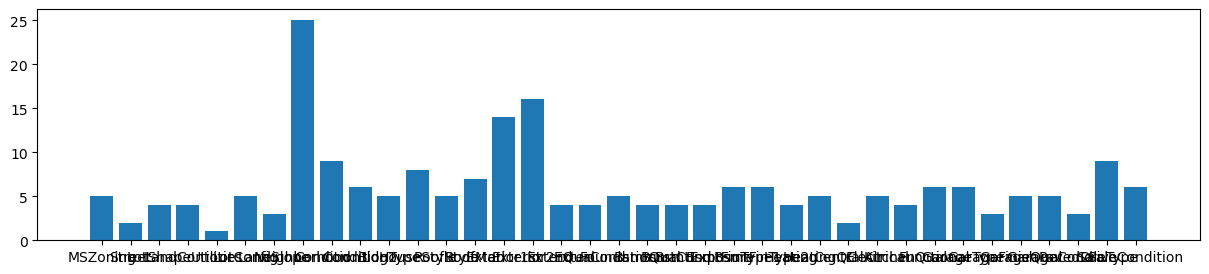

In [27]:
# Analyze the catagorival columns and find the required encoding for them
def cat_columns(df):
    col = df.dtypes == 'object'
    cat_col = col[col==True].index.tolist()
    
    return cat_col, df[cat_col].nunique()

cat_col,unique_val = cat_columns(df)
plt.figure(figsize=(15,3))
plt.bar(cat_col,unique_val)
plt.show()

In [28]:
#Do the encoding for categorical featues
df_dummies=pd.get_dummies(df,drop_first=True)
print(df_dummies.shape)

(1094, 217)


#### Correlation Analysis

In [30]:
df_dummies.corr()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
MSSubClass,1.000000,-0.389466,-0.197903,0.031639,-0.085553,0.021605,0.010178,0.040009,-0.069439,-0.073834,...,0.013170,0.029051,-0.051723,-0.026046,0.019577,-0.004418,0.015701,0.009364,0.038807,-0.058729
LotFrontage,-0.389466,1.000000,0.419714,0.241169,-0.047132,0.107958,0.082938,0.189769,0.239734,0.046928,...,0.015498,-0.050098,0.127724,0.000297,-0.093801,-0.013285,-0.014428,0.013588,-0.091191,0.125665
LotArea,-0.197903,0.419714,1.000000,0.169876,-0.033113,0.028954,0.024308,0.106600,0.232341,0.138615,...,0.009657,-0.012667,0.051151,-0.002872,-0.026873,-0.007268,-0.010571,-0.010218,-0.012396,0.055097
OverallQual,0.031639,0.241169,0.169876,1.000000,-0.189587,0.590761,0.568582,0.419756,0.230438,-0.081342,...,0.028875,0.011187,0.352632,-0.049765,-0.264598,-0.027625,-0.040644,-0.044490,-0.180462,0.347097
OverallCond,-0.085553,-0.047132,-0.033113,-0.189587,1.000000,-0.437647,0.024427,-0.174581,-0.068285,0.040598,...,0.020863,0.009895,-0.186046,-0.016340,0.175895,0.012035,-0.016896,-0.022686,0.177767,-0.180464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SaleCondition_AdjLand,-0.004418,-0.013285,-0.007268,-0.027625,0.012035,-0.031447,-0.051927,-0.017435,-0.008793,-0.008608,...,-0.001586,-0.001832,-0.010417,-0.000915,0.012793,1.000000,-0.002246,-0.003912,-0.061337,-0.010567
SaleCondition_Alloca,0.015701,-0.014428,-0.010571,-0.040644,-0.016896,-0.026390,-0.011533,0.016292,0.039622,-0.021135,...,-0.003894,-0.004499,-0.025575,-0.002246,0.031408,-0.002246,1.000000,-0.009605,-0.150590,-0.025944
SaleCondition_Family,0.009364,0.013588,-0.010218,-0.044490,-0.022686,-0.053570,-0.064737,-0.007820,0.013259,-0.004544,...,-0.006782,-0.007835,-0.044544,-0.003912,0.034674,-0.003912,-0.009605,1.000000,-0.262280,-0.045186
SaleCondition_Normal,0.038807,-0.091191,-0.012396,-0.180462,0.177767,-0.201848,-0.161362,-0.110308,-0.040813,0.075434,...,-0.018206,0.029873,-0.698384,-0.061337,0.677813,-0.061337,-0.150590,-0.262280,1.000000,-0.708444


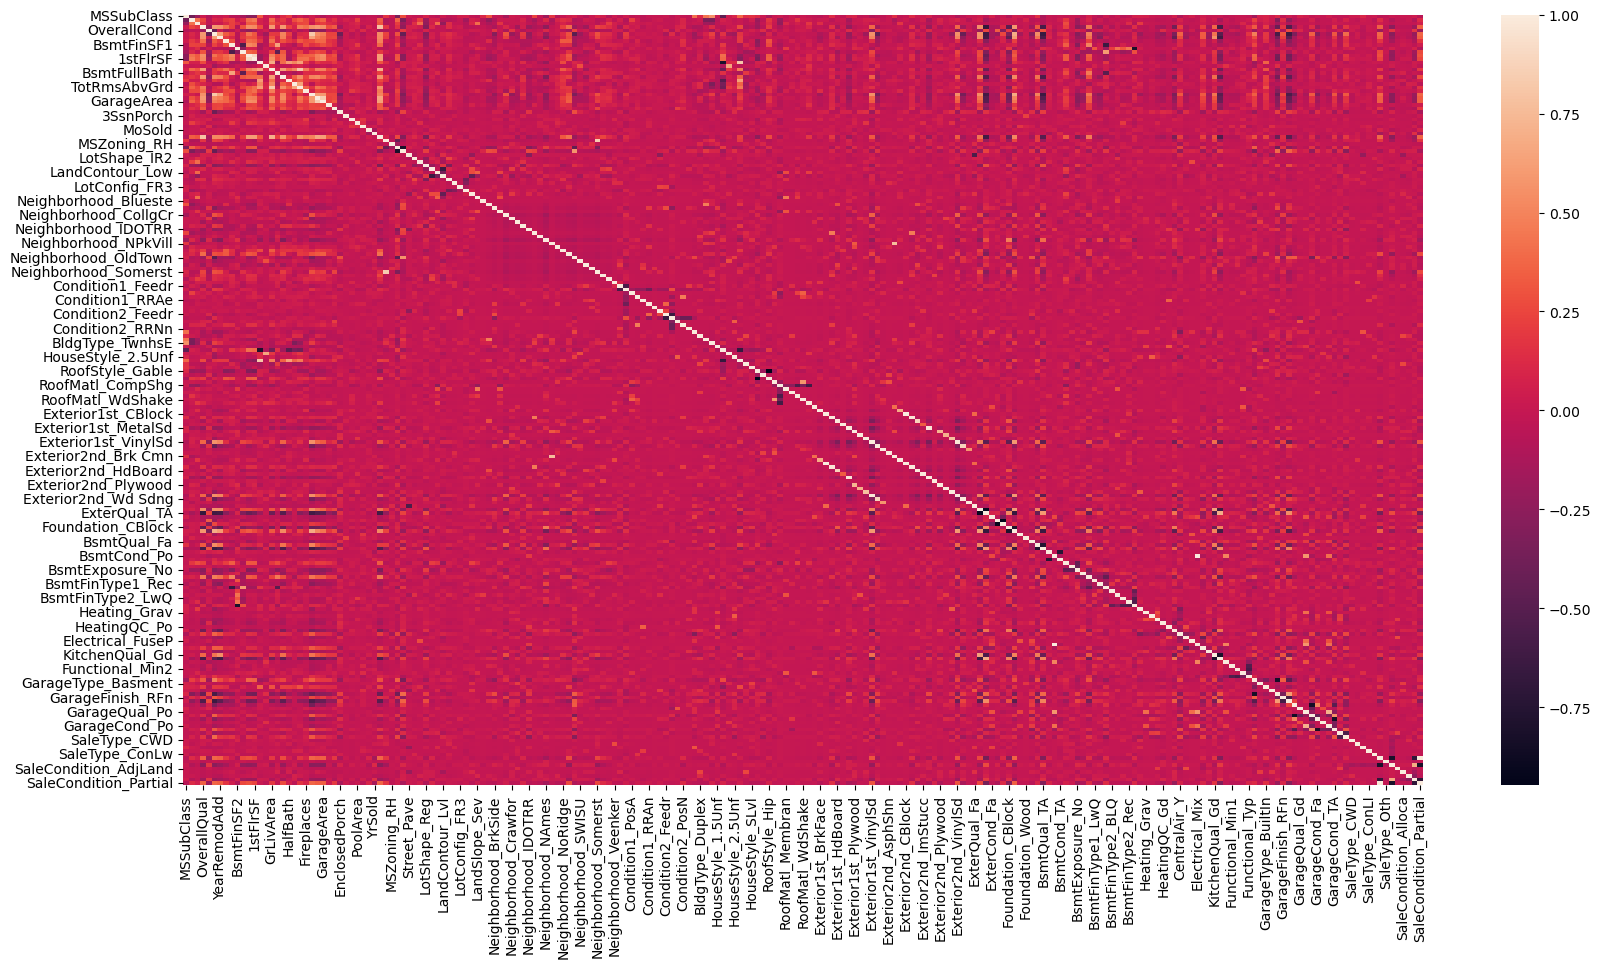

In [31]:
fig=plt.figure(figsize=(20,10))
sns.heatmap(df_dummies.corr())
plt.show()

#### Summary Statistics

In [33]:
#Get a described info for your data frame
df_dummies.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,...,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000
mean,56.128885,70.759598,10132.346435,6.247715,5.575868,1972.412249,1985.915905,109.855576,448.191956,45.252285,...,94.341865,46.946984,22.053016,3.266910,16.498172,3.007313,23.550274,6.335466,2007.786106,187033.263254
std,41.976345,24.508859,8212.249621,1.366797,1.066500,31.189752,20.930772,190.667459,468.728095,159.075003,...,122.624615,64.820019,61.570502,29.655973,58.455303,40.713175,167.135237,2.694558,1.334307,83165.332151
min,20.000000,21.000000,1300.000000,2.000000,2.000000,1880.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,35311.000000
25%,20.000000,60.000000,7606.750000,5.000000,5.000000,1953.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,132500.000000
50%,50.000000,70.000000,9444.500000,6.000000,5.000000,1975.000000,1995.000000,0.000000,384.500000,0.000000,...,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,165750.000000
75%,70.000000,80.000000,11387.250000,7.000000,6.000000,2003.000000,2005.000000,171.750000,712.750000,0.000000,...,169.750000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,221000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,648.000000,2500.000000,12.000000,2010.000000,755000.000000


### Prepare The Test and Train data

In [35]:
#Ready your data for model fitting
X = df_dummies.drop('SalePrice',axis=1)
y = df_dummies['SalePrice']
print(X.shape, y.shape)

(1094, 216) (1094,)


In [36]:
#Split the data for train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=.8, random_state=45)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(875, 216) (219, 216) (875,) (219,)


### Create Model and find the best model

In [38]:
#Fit to the models and find the best model
models=[]
Best_Model={}
models.append(('lr',LinearRegression()))
models.append(('DT',DecisionTreeRegressor()))
models.append(('RF',RandomForestRegressor()))
models.append(('GB',HistGradientBoostingRegressor()))
models.append(('SVR',SVR(gamma='auto')))
models.append(('GB',GaussianNB()))
models.append(('KNN',KNeighborsRegressor()))

for name,model in models:
    kfold=KFold(n_splits=10)
    crossvalscore=cross_val_score(model,X_train,y_train,scoring='r2',cv=kfold)
    Best_Model[model]=crossvalscore.mean()
    print('{}:model {}: cross_val_score {}:standard_deviation {}'.format(name,model,crossvalscore.mean(),crossvalscore.std()),'\n','\n')
    
Bestmodel_accuracy=max(Best_Model.values())
Bestmodel_Name=max(Best_Model,key=Best_Model.get)
print("Best model is ",Bestmodel_Name," and cross_val_score is : ",Bestmodel_accuracy)

lr:model LinearRegression(): cross_val_score 0.6670959050868627:standard_deviation 0.44748941448028634 
 

DT:model DecisionTreeRegressor(): cross_val_score 0.6301882199986262:standard_deviation 0.3446029567433819 
 

RF:model RandomForestRegressor(): cross_val_score 0.8053011530568565:standard_deviation 0.1748074803893864 
 

GB:model HistGradientBoostingRegressor(): cross_val_score 0.8184852129984606:standard_deviation 0.1497520981800039 
 

SVR:model SVR(gamma='auto'): cross_val_score -0.06933189052185484:standard_deviation 0.05342876859353023 
 

GB:model GaussianNB(): cross_val_score 0.6368599235500592:standard_deviation 0.12398918164071232 
 

KNN:model KNeighborsRegressor(): cross_val_score 0.6352458656213729:standard_deviation 0.06790720460178838 
 

Best model is  HistGradientBoostingRegressor()  and cross_val_score is :  0.8184852129984606


In [39]:
#Let's apply the best model and get the score
Bestmodel = Bestmodel_Name.fit(X_train,y_train)
y_pred = Bestmodel.predict(X_test)
print('The best model is {} and the score is {}'.format(Bestmodel_Name,r2_score(y_pred,y_test)))

The best model is HistGradientBoostingRegressor() and the score is 0.8304407592432114


## Conclusion

In this project, we successfully developed a machine learning model for predicting house prices. The model achieved a 83% on the test data, demonstrating its ability to learn the underlying relationships between various house characteristics and their corresponding prices.

This model can be a valuable tool for various stakeholders in the real estate market:

    1. Homebuyers: The model can provide potential buyers with a more informed estimate of a house's value, empowering them to make better decisions during negotiations.
    2. Real Estate Agents: Agents can leverage the model's predictions to set more competitive listing prices and inform their clients about market trends.
    3. Investors: Investors can utilize the model to identify potentially undervalued properties and make data-driven investment decisions.
    
However, it's important to acknowledge that the model's predictions should not be considered absolute truths. House prices are influenced by various factors beyond the scope of the data used for training,  such as market fluctuations and unforeseen events.
